# ToDo:
- get a set of epoch-data based on author birth (20 years before period starts as a criterium) so we can color our data
- rearrange the code to work in a single function, so we can do fast experiments!
- do some experiments with perplexity

# Tsne

In [1]:
import pandas as pd

In [2]:
meta = pd.read_csv("metadata.csv", encoding="utf8", sep=";")
meta.head()

,Unnamed: 0,title,author,filename,pubyear,genre,sources
0,40,Geschichte des Agathon,Christoph Martin Wieland,wieland_agathon01_1766.txt,1767.0,Prosa,https://www.deutschestextarchiv.de/book/show/w...
1,41,Geschichte des Agathon,Christoph Martin Wieland,wieland_agathon02_1767.txt,1767.0,Prosa,https://www.deutschestextarchiv.de/book/show/w...
2,38,Geschichte des Fräuleins von Sternheim,Christoph Martin Wieland,laroche_geschichte01_1771.txt,1771.0,Roman,https://www.deutschestextarchiv.de/book/show/l...
3,39,Geschichte des Fräuleins von Sternheim,Christoph Martin Wieland,laroche_geschichte02_1771.txt,1771.0,Roman,https://www.deutschestextarchiv.de/book/show/l...
4,237,Geschichte des Fräuleins von Sternheim,Sophie von La Roche,laroche_geschichte01_1771.txt,1771.0,Roman,https://www.deutschestextarchiv.de/book/show/l...


In [3]:
author_table = pd.read_csv("src/author_table.tsv", sep="\t", encoding = "utf8")
author_table.head()

,ID,Voller_Name,Nachname,Vorname,Geburtsjahr,Todesjahr,Nationalität,Geschlecht,Gutenberg,Zeno,DTA,WikiSource,Kolimo+,Anmerkung
0,1,Abraham Emanuel Fröhlich,NaN,NaN,1796,1865.0,CHE,m,https://www.projekt-gutenberg.org/autoren/name...,NaN,NaN,https://de.wikisource.org/wiki/Abraham_Emanuel...,NaN,NaN
1,2,Achim von Arnim,von Arnim,Achim,1781,1831.0,DEU,m,https://www.projekt-gutenberg.org/autoren/name...,"http://www.zeno.org/Literatur/M/Arnim,+Ludwig+...",https://www.deutschestextarchiv.de/api/pnd/118...,https://de.wikisource.org/wiki/Achim_von_Arnim,NaN,NaN
2,3,"Ada Christen, eigentlich Christiane von Breden",NaN,NaN,1844,1901.0,AUT,f,NaN,"http://www.zeno.org/Literatur/M/Christen,+Ada",NaN,https://de.wikisource.org/wiki/Ada_Christen,NaN,NaN
3,4,Ada von Gersdorff,NaN,NaN,1854,1922.0,DEU,f,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Adalbert Stifter,NaN,NaN,1805,1868.0,AUT,m,https://www.projekt-gutenberg.org/autoren/name...,"http://www.zeno.org/Literatur/M/Stifter,+Adalbert",https://www.deutschestextarchiv.de/api/pnd/118...,https://de.wikisource.org/wiki/Adalbert_Stifter,NaN,NaN


In [4]:
author_table["Geburtsjahr"].isnull().values.any()

False

In [5]:
author_table["Geburtsjahr"].describe()

count    1385.000000
mean     1826.512635
std        38.270656
min      1720.000000
25%      1802.000000
50%      1834.000000
75%      1858.000000
max      1895.000000
Name: Geburtsjahr, dtype: float64

In [6]:
periods=[]

for author in list(meta["author"]):
    birthyear = author_table["Geburtsjahr"].loc[author_table["Voller_Name"]==author]
    
    if int(birthyear.iloc[0])<1811:
        periods.append("Kunstepoche")
    elif (int(birthyear.iloc[0]) >= 1811) & (int(birthyear.iloc[0]) <=1830):
        periods.append("Vormärz")
    elif (int(birthyear.iloc[0]) > 1831) & (int(birthyear.iloc[0]) <=1870):
        periods.append("Realismus")
    else:
        periods.append("Moderne")
    
len(periods)

1764

In [7]:
genders=[]

for author in list(meta["author"]):
    gender = author_table["Geschlecht"].loc[author_table["Voller_Name"]==author]
    
    genders.append(gender.iloc[0])
    
len(genders)

1764

In [8]:
len(meta)

1764

In [9]:
corpus = []

for file in list(meta["filename"]):
    with open("src/corpus_nostopwords/" + file, encoding="utf8") as f:
        corpus.append(f.read())

In [10]:
len(corpus)

1764

## tf-ifd

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
vectorizer = CountVectorizer(min_df=20,
                             # max_df=100,
                             lowercase=True,
                             max_features=20000
                             )

X = vectorizer.fit_transform(corpus)

## Tsne

In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import plotly.express as px

In [14]:
def make_tsne(input_matrix, dim_reduction, n_perplexity, n_iterations):
    
    # dimension reduction
    svd = TruncatedSVD(n_components=dim_reduction, random_state=42)
    data = svd.fit_transform(input_matrix)
    
    X_embedded = TSNE(n_components=2,
                  learning_rate='auto',
                  init='random',
                  n_iter=n_iterations,
                  perplexity=n_perplexity).fit_transform(data)
    
    # building the dataset
    df=pd.DataFrame()
    df["title"]=list(meta["title"])
    df["author"]=list(meta["author"])
    df["period"]=periods
    df["gender"]=genders
    df=df.join(pd.DataFrame(X_embedded))
    df=df.rename(columns={0:"Dim 1", 1:"Dim 2"})
    
    # plotting
    # title="dim: " + str(dim_reduction) + ", perp: " + str(n_perplexity) + ", iter: " + str(n_iterations)
    title = "Fig 4: A first exploration of the corpus based on MFW and gender"
    
    fig = px.scatter(df,
                     x="Dim 1",
                     y="Dim 2",
                     hover_data=["title", "author", "period"],
                     color="gender",
                     color_discrete_sequence=['#053c6c', '#9d95b0' ],
                     title=title)
    
    fig.update_layout({"plot_bgcolor":"#ffbb91", "paper_bgcolor":"#feba67", "height":750, "width":1000,},
                      xaxis=dict(showgrid=False),
                      yaxis=dict(showgrid=False),
                      title_font_color="#122630",
                      title=dict(font=dict(size=28), yref='paper')
                      )
    
    fig.show()

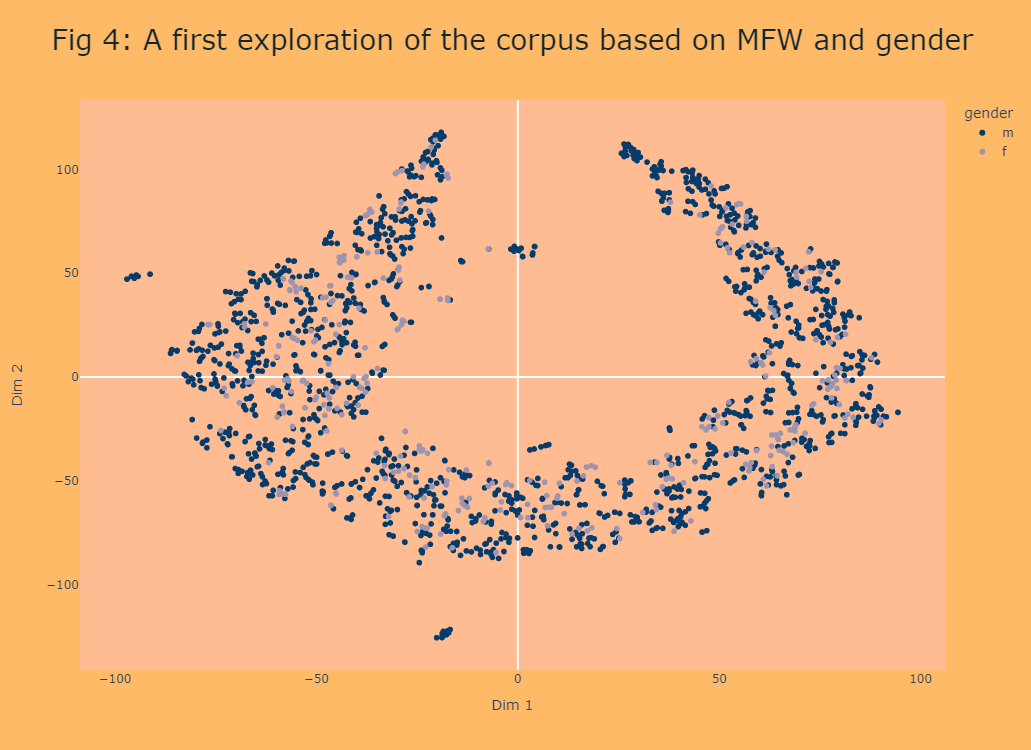

In [17]:
make_tsne(X, 2000, 10, 5000)

In [16]:
# for dim in [500, 1000, 1500, 2000]:    
#     for perp in [10, 30, 50, 70]:
#         for iteration in [1000, 2000, 3000, 4000, 5000]:
#             make_tsne(X, dim, perp, iteration)